In [1]:
import time
import numpy as np

import tensorflow as tf

from tensorflow.python.framework import function

import scipy.io as sio
traindata = sio.loadmat('../dataset/mnist_training.mat')
testdata = sio.loadmat('../dataset/mnist_test.mat')

xtrain = traindata['Xtraining']
xtest = testdata['Xtest']


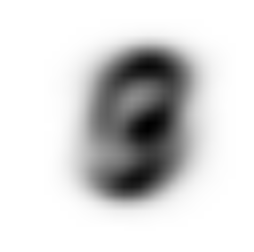

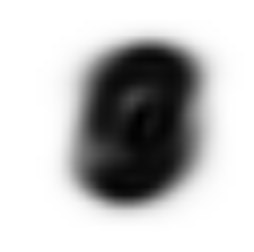

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def show(digit_vector):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """

    images = np.array(digit_vector).reshape((28, 28))

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    imgplot = ax.imshow(images, cmap=mpl.cm.Greys)
    plt.axis('off')
    plt.grid('off')
    plt.show()
    
xbatch = xtrain;
xmean = xbatch.mean(axis=0).astype('float64')
xvar = np.clip(xbatch.var(axis=0), 1e-7, np.inf).astype('float64')

show(xmean)
show(xvar)


summary_err = np.zeros((4, 50))
summary_time = np.zeros((4, 1))

In [3]:
# reduced MRF with stochastic neuron 

dim_input = 28 * 28
dim_hidden= 64
batch_size = 500
learning_rate = 1e-2
max_iter = 5000

alpha = 1e-3
beta = 1e-3

def VAE_stoc_neuron(alpha, batch_size, learning_rate, max_iter):
    
    g = tf.Graph()
    dtype = tf.float32
    
    with g.as_default():
        x = tf.placeholder(dtype, [None, dim_input])
        
        # define doubly stochastic neuron with gradient by DeFun
        @function.Defun(dtype, dtype, dtype, dtype)
        def DoublySNGrad(logits, epsilon, dprev, dpout):
            prob = 1.0 / (1 + tf.exp(-logits))
            yout = (tf.sign(prob - epsilon) + 1.0) / 2.0

            # unbiased
            dlogits = prob * (1 - prob) * (dprev + dpout)
            
            depsilon = dprev
            return dlogits, depsilon

        @function.Defun(dtype, dtype, grad_func=DoublySNGrad)
        def DoublySN(logits, epsilon):
            prob = 1.0 / (1 + tf.exp(-logits))
            yout = (tf.sign(prob - epsilon) + 1.0) / 2.0
            return yout, prob
        
        with tf.name_scope('encode'):
            wencode = tf.Variable(tf.random_normal([dim_input, dim_hidden], stddev=1.0 / tf.sqrt(float(dim_input)), dtype=dtype),
                                       name='wencode')
            bencode = tf.Variable(tf.random_normal([dim_hidden], dtype=dtype), name='bencode')
            hencode = tf.matmul(x, wencode) + bencode
            # determinastic output
            hepsilon = tf.ones(shape=tf.shape(hencode), dtype=dtype) * .5
            
        yout, pout = DoublySN(hencode, hepsilon)
        
        with tf.name_scope('decode'):
            wdecode = tf.Variable(tf.random_normal([dim_hidden, dim_input], stddev=1.0 / tf.sqrt(float(dim_hidden)), dtype=dtype), 
                                  name='wdecode')
        with tf.name_scope('scale'):
            scale_para = tf.Variable(tf.constant(xvar, dtype=dtype), name="scale_para")
            shift_para = tf.Variable(tf.constant(xmean, dtype=dtype), name="shift_para")
            
        xout = tf.matmul(yout, wdecode) * tf.abs(scale_para) + shift_para
        
        monitor = tf.nn.l2_loss(xout - x, name=None) 
        loss = monitor + alpha * tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(hencode, yout)) + beta * tf.nn.l2_loss(wdecode, name=None)

        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        # optimizer = tf.train.RMSPropOptimizer(learning_rate)
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(loss)

        sess = tf.Session(graph=g)
        sess.run(tf.initialize_all_variables())
        
        train_err = []
        for i in xrange(max_iter):
            indx = np.random.choice(xtrain.shape[0], batch_size)
            xbatch = xtrain[indx]
            _, monitor_value, loss_value = sess.run([train_op, monitor, loss], feed_dict={x: xbatch})

            if i % 100 == 0:
                print('Num iteration: %d Loss: %0.04f Monitor Loss %0.04f' %(i, loss_value / batch_size, monitor_value / batch_size))
                train_err.append(loss_value)
    
        node_list = ['yout', 'pout', 'xout', 'wencode', 'bencode', 'wdecode', 'scale_para', 'shift_para']
        t_vars = tf.trainable_variables()

        para_list = {}
        for var in t_vars:
            para_list[var.name] = sess.run(var)
    
    return g, node_list, para_list, train_err

start_time = time.time()
g, node_list, para_list, train_err = VAE_stoc_neuron(alpha, batch_size, learning_rate, max_iter)
end_time = (time.time() - start_time)

Num iteration: 0 Loss: 28.8529 Monitor Loss 28.8240
Num iteration: 100 Loss: 10.2225 Monitor Loss 10.2047
Num iteration: 200 Loss: 9.6809 Monitor Loss 9.6636
Num iteration: 300 Loss: 9.3118 Monitor Loss 9.2947
Num iteration: 400 Loss: 9.5522 Monitor Loss 9.5352
Num iteration: 500 Loss: 9.2947 Monitor Loss 9.2778
Num iteration: 600 Loss: 9.3382 Monitor Loss 9.3211
Num iteration: 700 Loss: 9.2176 Monitor Loss 9.2006
Num iteration: 800 Loss: 9.0780 Monitor Loss 9.0610
Num iteration: 900 Loss: 8.8890 Monitor Loss 8.8721
Num iteration: 1000 Loss: 8.8284 Monitor Loss 8.8114
Num iteration: 1100 Loss: 8.8959 Monitor Loss 8.8789
Num iteration: 1200 Loss: 8.9491 Monitor Loss 8.9321
Num iteration: 1300 Loss: 9.2430 Monitor Loss 9.2262
Num iteration: 1400 Loss: 8.8483 Monitor Loss 8.8316
Num iteration: 1500 Loss: 8.7944 Monitor Loss 8.7775
Num iteration: 1600 Loss: 8.6762 Monitor Loss 8.6591
Num iteration: 1700 Loss: 8.8182 Monitor Loss 8.8013
Num iteration: 1800 Loss: 8.5700 Monitor Loss 8.5531
N

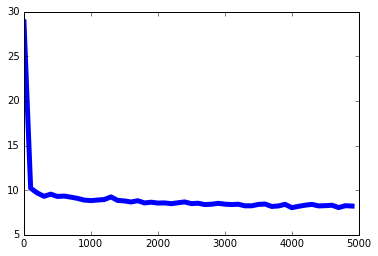

In [4]:
plt.plot(np.array(range(len(train_err))) * 100, np.array(train_err) / 500, linewidth=5)
plt.show()

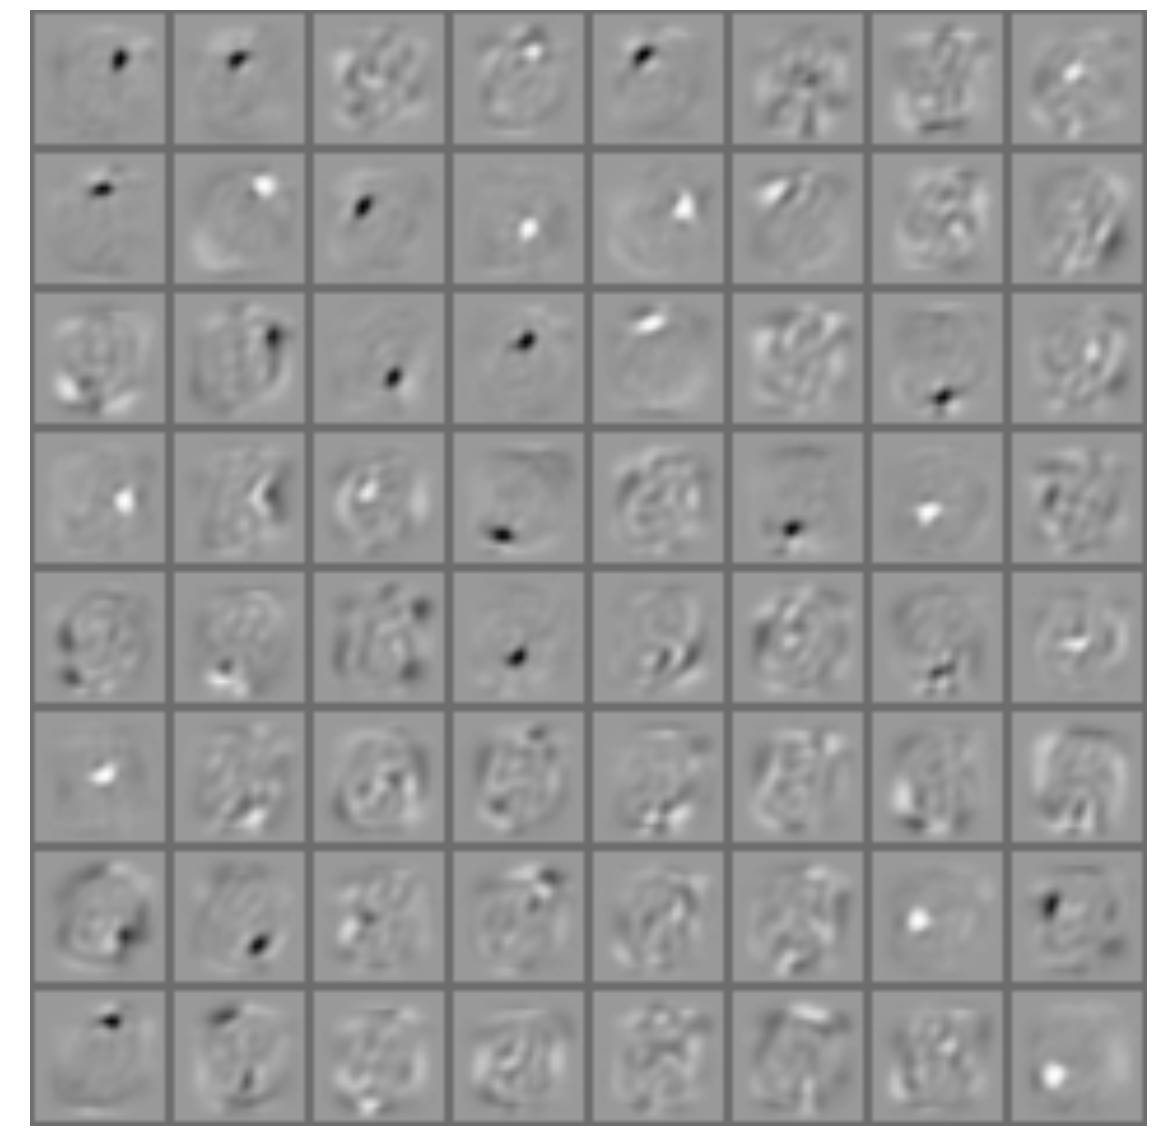

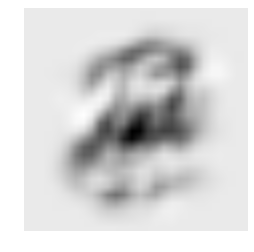

In [5]:
nrow = 8;

# check the learned template. It will generate the figure 6. in Appendix.

U = para_list['decode/wdecode:0']
shift = para_list['scale/shift_para:0']

np.pad(U[1].reshape(28, 28), ((1,1), (1,1)), mode='constant', constant_values=((0, 0), (0, 0))).shape

  
template = np.vstack([np.hstack([np.pad(U[j].reshape(28, 28), ((1,1), (1,1)), mode='constant', constant_values=((1, 1), (1, 1)))
                                 for j in range(i*nrow, i*nrow+nrow)]) for i in range(int(dim_hidden / nrow))])

plt.figure(figsize = (20,20))
plt.imshow(template, cmap=mpl.cm.Greys)
plt.axis('off')
plt.grid('off')
plt.show()

plt.imshow(shift.reshape(28, 28), cmap=mpl.cm.Greys)
plt.axis('off')
plt.grid('off')
plt.show()



In [6]:

# compute binary codes via median

traindata = sio.loadmat('../dataset/mnist_training.mat')
testdata = sio.loadmat('../dataset/mnist_test.mat')

imgtrain = traindata['Xtraining']
img = testdata['Xtest']

W = para_list['encode/wencode:0']
b = para_list['encode/bencode:0']


logits = np.dot(np.array(img), W) + b
epsilon = 0.5 

pres = 1.0 / (1 + np.exp(-logits))
hres = (np.sign(pres - epsilon) + 1.0) / 2.0

trainlogits = np.dot(np.array(imgtrain), W) + b
epsilon = 0.5 

trainpres = 1.0 / (1 + np.exp(-trainlogits))
htrain = (np.sign(trainpres - epsilon) + 1.0) / 2.0
htest = hres

print htrain.shape

(55000, 64)


In [7]:
# PCA

dim_hashing = 64
dim_input = imgtrain.shape[1]
xtrain = imgtrain

covmat = np.dot((xtrain - xmean).T, (xtrain - xmean))
eigval, eigvec = np.linalg.eigh(covmat)

Upca = eigvec[:, -1: dim_input - dim_hashing - 1:-1]
W = np.dot(Upca, np.linalg.inv(np.dot(Upca.T, Upca)))
h = np.dot(xtrain - xmean, W)
xrec = np.dot(h, Upca.T) + xmean


In [8]:
# ITQ algorithm

dim_hashing = 64

Uitq = eigvec[:, -1: dim_input - dim_hashing - 1:-1]
V = np.dot(xtrain, Uitq)
B = np.sign(V)

itqrec = np.dot(B, Uitq.T) + xmean  
l2_loss = np.mean(np.sum((xtrain - itqrec)**2, axis=1)) / 2
print('Loss: %0.04f' %(l2_loss) )


max_iter = 10
for i in xrange(max_iter):
    ### alternative optimize the B and R ###
    temp = np.dot(B.T, V)
    G, s, Gt = np.linalg.svd(temp, full_matrices=False)
    R = np.dot(Gt.T, G.T)
    B = np.sign(np.dot(V, R))
    itqrec = np.dot(np.dot(B, R.T), Uitq.T) + xmean  
    l2_loss = np.mean(np.sum((xtrain - itqrec)**2, axis=1)) / 2
    print('Num iteration: %d Loss: %0.04f' %(i, l2_loss) )

Loss: 26.7411
Num iteration: 0 Loss: 29.1939
Num iteration: 1 Loss: 30.1897
Num iteration: 2 Loss: 29.5092
Num iteration: 3 Loss: 28.9141
Num iteration: 4 Loss: 28.4708
Num iteration: 5 Loss: 28.1711
Num iteration: 6 Loss: 27.9496
Num iteration: 7 Loss: 27.7743
Num iteration: 8 Loss: 27.6368
Num iteration: 9 Loss: 27.5082


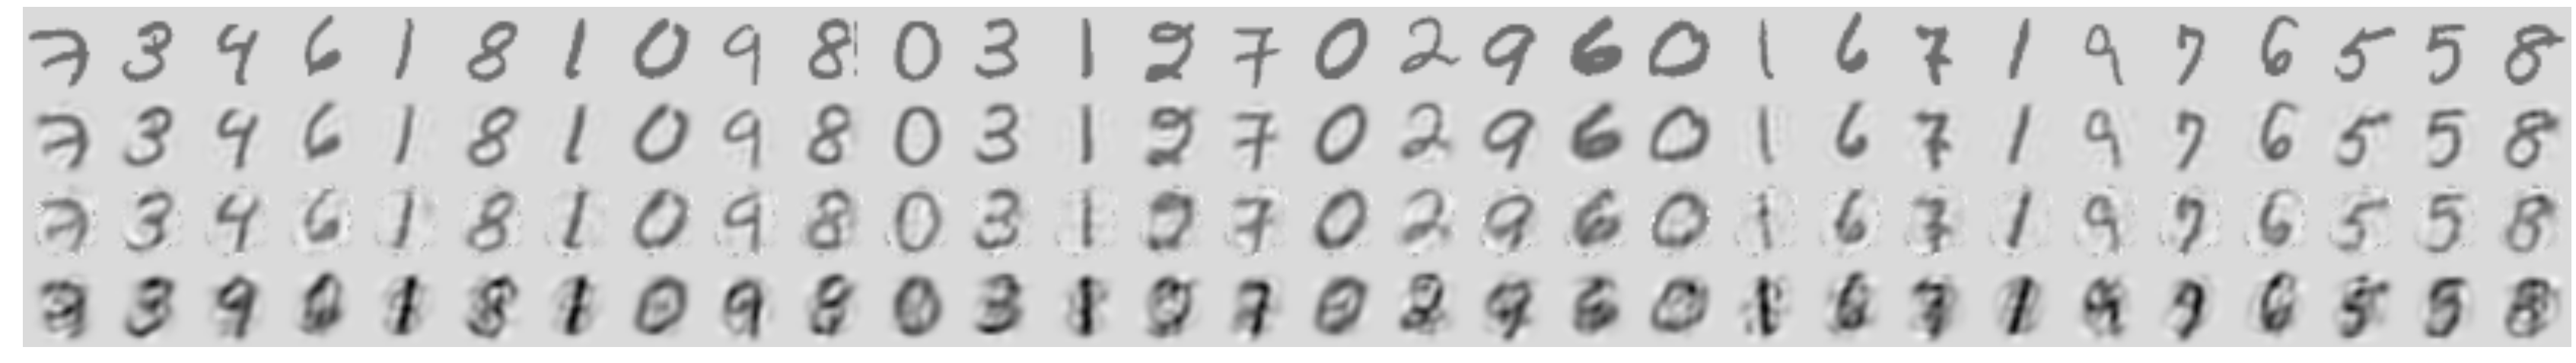

In [9]:

# reconstruct the image via the learned codes and templates. It generates the Figure 3. in main text.

W = para_list['encode/wencode:0']
b = para_list['encode/bencode:0']

shift = para_list['scale/shift_para:0']
scale = para_list['scale/scale_para:0']

U = para_list['decode/wdecode:0']


img_frame = 30
img = xtrain[range(img_frame)]

logits = np.dot(np.array(img), W) + b
epsilon = 0.5 

pres = 1.0 / (1 + np.exp(-logits))
hres = (np.sign(pres - epsilon) + 1.0) / 2.0

template = np.hstack([np.vstack([xtrain[j].reshape(28, 28), 
                                 xrec[j].reshape(28, 28),
                                 ((np.dot(hres[j], U) ) * scale + shift).reshape((28, 28)),
                                 itqrec[j].reshape(28, 28)]) 
                                 for j in range(img_frame)])

    
plt.figure(figsize = (60, 60))
plt.imshow(template, cmap=mpl.cm.Greys)
plt.axis('off')
plt.grid('off')
plt.show()